In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive")

ModuleNotFoundError: No module named 'google.colab'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from fast_ml.model_development import train_valid_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [13]:
# loanData = pd.read_csv('DM1 Project/CleanedData/cleanLoanData.csv')
# loanData = loanData.drop(columns = ['Unnamed: 0'])

In [14]:
loanData = pd.read_csv('cleanLoanData.csv')
loanData = loanData.drop(columns = ['Unnamed: 0'])

#### Splitting into Train-Test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(loanData, target = 'MIS_Status',train_size=0.8, valid_size=0.1, test_size=0.1) 

In [16]:
#checking shapes of all splitted sets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(206864, 19)
(206864,)
(25858, 19)
(25858,)
(25858, 19)
(25858,)


### Scaling the dataset for feature importance selections

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

#### Selecting scores of features

In [18]:
bestfeatures = SelectKBest(score_func = f_classif, k='all')
fit = bestfeatures.fit(X_train, y_train)
scores = pd.DataFrame(fit.scores_.round(6))
columns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([columns, scores], axis = 1)
featureScores.columns = ['Feature','Score']
featureScores = featureScores.sort_values('Score', ascending = False, ignore_index=True)
featureScores

,Feature,Score
0,ChgOffPrinGr,62051.640818
1,Term,40148.776720
2,SBA_Gurantee_percent,9635.735337
3,IsDisbLargerThanGrAppv,4612.730982
4,DisbursementDuration_days,2761.436626
5,LowDoc,2711.831449
6,SBA_Appv,2224.115168
7,GrAppv,1553.651359
8,RevLineCr,1411.845550
9,DisbursementGross,991.092725


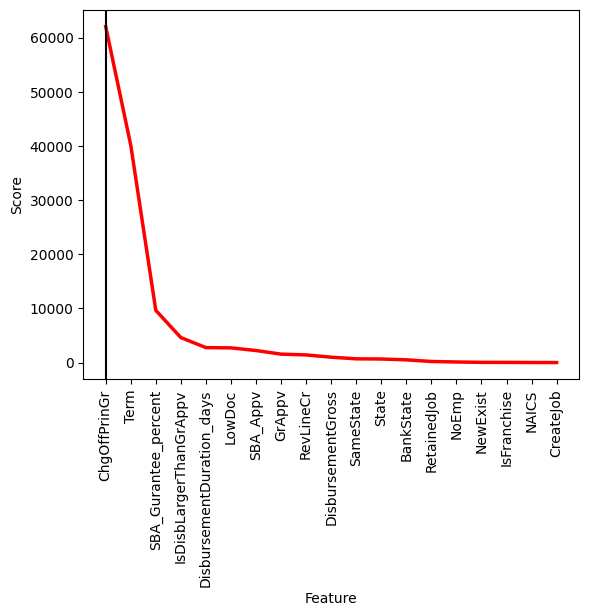

In [19]:
sns.lineplot(data = featureScores, x = "Feature", y = "Score", color = "red", linewidth=2.5)
max_valued_feature = featureScores.loc[featureScores['Score'] == featureScores['Score'].max(), 'Feature'].iloc[0]
plt.axvline(max_valued_feature, color = 'black')
plt.xticks(rotation = 90)
plt.show()

In [11]:
#Dropping features
loan_data_fdrop = loanData.drop(['State','BankState','RetainedJob','NoEmp','NewExist','IsFranchise','NAICS','CreateJob'], axis = 1)

#Spliting into train-val-test
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(loan_data_fdrop, target = 'MIS_Status',train_size=0.8, valid_size=0.1, test_size=0.1) 

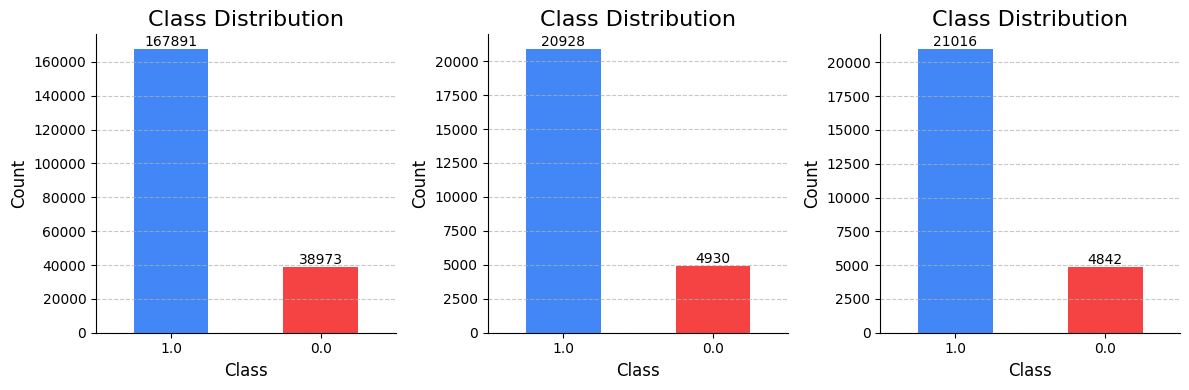

In [12]:
import matplotlib.pyplot as plt

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
colors = ['#4287f5', '#f54242']  # Custom color palette

for i, subplot in enumerate([ax, ax2, ax3]):
    y_values = [y_train, y_val, y_test][i]
    y_values.value_counts().plot(kind='bar', ax=subplot, color=colors)

    # Customize the plot
    subplot.set_title('Class Distribution', fontsize=16)
    subplot.set_xlabel('Class', fontsize=12)
    subplot.set_ylabel('Count', fontsize=12)
    subplot.tick_params(axis='x', rotation=0, labelsize=10)
    subplot.tick_params(axis='y', labelsize=10)
    subplot.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels to the bars
    for p in subplot.patches:
        subplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='center', xytext=(0, 5),
                         textcoords='offset points', fontsize=10, color='black')

    # Remove the spines
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Grid Search for XGBoost

#### XGBoost

In [20]:
clf = XGBClassifier(random_state = 0)

In [21]:
clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [22]:
pipe_xgboost = Pipeline([('scaler', StandardScaler()),('clf', XGBClassifier(random_state = 0))])

In [23]:
xg_params = {
     'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()],
     'clf__booster': ['gbtree','dart'],
     'clf__colsample_bytree': [1, 3],
     'clf__learning_rate': [0.1, 0.3],
     'clf__max_delta_step': [0, 1],
     'clf__max_depth': [None, 2, 5, 10],
     'clf__min_child_weight': [1, 2],
     'clf__n_estimators': [10, 50, 100, 200, 500],
     'clf__objective': ['binary:logistic'],
     'clf__reg_lambda': [1, 2, 3],
     'clf__scale_pos_weight': [1, 2],
     'clf__subsample': [1],
     'clf__verbosity': [1]}

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 0) #5 Fold cv repeated 2 times

The factor param controls the rate at which the resources grow and the rate at which the number of candidates decrease. Per iter :-> n_reources*factor and n_candidates/factor

In [24]:
gs = HalvingGridSearchCV(pipe_xgboost, xg_params, scoring="f1_macro", n_jobs=-1, min_resources="exhaust", factor=3, verbose = 1, cv = cv)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_val)

n_iterations: 8
n_required_iterations: 9
n_possible_iterations: 8
min_resources_: 40
max_resources_: 206864
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15360
n_resources: 40
Fitting 10 folds for each of 15360 candidates, totalling 153600 fits
----------
iter: 1
n_candidates: 5120
n_resources: 120
Fitting 10 folds for each of 5120 candidates, totalling 51200 fits
----------
iter: 2
n_candidates: 1707
n_resources: 360
Fitting 10 folds for each of 1707 candidates, totalling 17070 fits
----------
iter: 3
n_candidates: 569
n_resources: 1080
Fitting 10 folds for each of 569 candidates, totalling 5690 fits
----------
iter: 4
n_candidates: 190
n_resources: 3240
Fitting 10 folds for each of 190 candidates, totalling 1900 fits
----------
iter: 5
n_candidates: 64
n_resources: 9720
Fitting 10 folds for each of 64 candidates, totalling 640 fits
----------
iter: 6
n_candidates: 22
n_resources: 29160
Fitting 10 folds for each of 22 candidates, totalling 220 fits
---------

:::Results:::

In [26]:
print("accuracy",metrics.accuracy_score(y_val, y_pred))
print("f1 score macro",metrics.f1_score(y_val, y_pred, average='macro')) 
print("f1 score micro",metrics.f1_score(y_val, y_pred, average='micro')) 
print("precision score",metrics.precision_score(y_val, y_pred, average='macro')) 
print("recall score",metrics.recall_score(y_val, y_pred, average='macro')) 
print("hamming_loss",metrics.hamming_loss(y_val, y_pred))
print("classification_report \n", metrics.classification_report(y_val, y_pred))

accuracy 0.9935029778018408
f1 score macro 0.9895958726374696
f1 score micro 0.9935029778018408
precision score 0.9840656362342224
recall score 0.9953660110042118
hamming_loss 0.006497022198159177
classification_report 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4930
         1.0       1.00      0.99      1.00     20928

    accuracy                           0.99     25858
   macro avg       0.98      1.00      0.99     25858
weighted avg       0.99      0.99      0.99     25858



In [27]:
# Printing the number of resouces exhausted in each iteration
print("Number of resources used in each iteration: ", gs.n_resources_)

# Printing out the best parameters for the selected classifier
print('Best Parameters: ', gs.best_params_)

# Access the best set of parameters
best_params_xg = gs.best_params_

# Stores the optimum model in best_pipe
best_pipe_xg = gs.best_estimator_

results_df_xg = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')
results_df_xg

Number of resources used in each iteration:  [40, 120, 360, 1080, 3240, 9720, 29160, 87480]
Best Parameters:  {'clf__booster': 'dart', 'clf__colsample_bytree': 1, 'clf__learning_rate': 0.1, 'clf__max_delta_step': 0, 'clf__max_depth': 2, 'clf__min_child_weight': 2, 'clf__n_estimators': 50, 'clf__objective': 'binary:logistic', 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1, 'clf__subsample': 1, 'clf__verbosity': 1, 'scaler': StandardScaler()}


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__booster,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_delta_step,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0,40,0.014079,0.000612,0.006337,0.000327,gbtree,1,0.1,0,...,1.000000,1.000000,1.000000,1.000000,1.00,0.944742,0.959477,1.000000,0.984896,0.023383
1,0,40,0.012477,0.001640,0.005856,0.000870,gbtree,1,0.1,0,...,1.000000,1.000000,1.000000,1.000000,1.00,0.944742,0.959477,1.000000,0.984896,0.023383
2,0,40,0.013990,0.000534,0.005823,0.000376,gbtree,1,0.1,0,...,1.000000,1.000000,1.000000,1.000000,1.00,0.944742,0.959477,1.000000,0.984896,0.023383
3,0,40,0.010784,0.000466,0.005897,0.000356,gbtree,1,0.1,0,...,1.000000,1.000000,1.000000,1.000000,1.00,0.944742,0.959477,1.000000,0.984896,0.023383
4,0,40,0.010469,0.000725,0.005299,0.000842,gbtree,1,0.1,0,...,1.000000,1.000000,1.000000,1.000000,1.00,0.944742,0.956028,1.000000,0.984551,0.023778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,7,87480,1.966198,0.023540,0.034098,0.008791,gbtree,1,0.1,0,...,0.989491,0.990353,0.989599,0.989743,0.99,0.989723,0.989847,0.989961,0.989791,0.000265
23036,7,87480,0.622630,0.044875,0.064049,0.008221,dart,1,0.1,0,...,0.989491,0.990351,0.989599,0.989743,0.99,0.989722,0.989847,0.989961,0.989791,0.000265
23037,7,87480,0.642003,0.018840,0.060887,0.001110,dart,1,0.1,1,...,0.989491,0.990353,0.989599,0.989743,0.99,0.989722,0.989847,0.989961,0.989791,0.000265
23038,7,87480,1.919219,0.066987,0.028292,0.001116,gbtree,1,0.1,0,...,0.989491,0.990353,0.989599,0.989743,0.99,0.989723,0.989847,0.989961,0.989791,0.000265


Training using the best parameters obtained by Grid Search

In [28]:
tuned_xgb_pipe = Pipeline([('scaler',StandardScaler()),
                          ('clf', XGBClassifier(n_estimators = 50,
                                                booster = 'dart', 
                                                colsample_bytree = 1, 
                                                learning_rate = 0.1,
                                                max_delta_step = 0, 
                                                max_depth = 2, 
                                                min_child_weight = 2,
                                                objective = 'binary:logistic',
                                                reg_lambda = 1,
                                                scale_pos_weight = 1,
                                                subsample = 1,
                                                verbosity = 1))])

#### Retraining the whole training set and predicting on test

In [29]:
#Dropping features
loan_data_fdrop = loanData.drop(['State','BankState','RetainedJob','NoEmp','NewExist','IsFranchise','NAICS','CreateJob'], axis = 1)
X = loan_data_fdrop.drop(['MIS_Status'], axis = 1)
y = loan_data_fdrop['MIS_Status']

#Spliting into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0, shuffle = True)

In [30]:
tuned_xgb_pipe.fit(X_train, y_train)
y_xgtest_pred = tuned_xgb_pipe.predict(X_test)

In [31]:
def plot_confusion_matrix(y_true, y_pred, labels = ['CHGOFF', 'PIF'],
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = metrics.confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

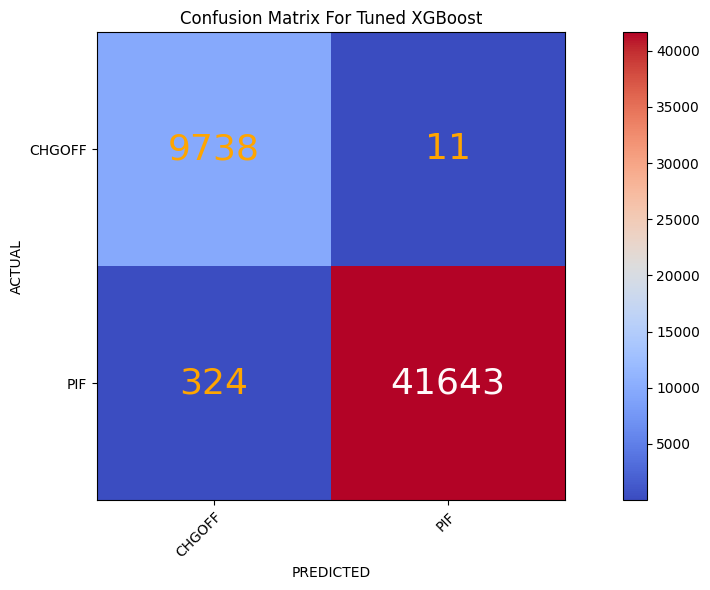

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      9749
         1.0       1.00      0.99      1.00     41967

    accuracy                           0.99     51716
   macro avg       0.98      1.00      0.99     51716
weighted avg       0.99      0.99      0.99     51716



In [32]:
plot_confusion_matrix(y_test, y_xgtest_pred, title="Confusion Matrix For Tuned XGBoost")
np.set_printoptions(precision=1)
plt.show()

# Final Classification Report
print(metrics.classification_report(y_test, y_xgtest_pred))

In [40]:
mask = np.logical_not(np.equal(y_test, y_xgtest_pred))

print("Elements wrongly classified: ")
wrongDF = X_test[mask]
print(wrongDF.shape)
wrongDF.describe()

Elements wrongly classified: 
(335, 11)


,Term,RevLineCr,LowDoc,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDuration_days,SameState,SBA_Gurantee_percent,IsDisbLargerThanGrAppv
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,35.644776,0.501493,0.041791,65023.056716,23172.710448,50974.677612,33855.450746,70.244776,0.080597,0.573304,0.465672
std,36.031620,0.500746,0.200411,113761.534746,68442.000823,107389.714693,84129.312193,94.878806,0.272622,0.141092,0.499566
min,0.000000,0.000000,0.000000,4412.000000,0.000000,1500.000000,750.000000,1.000000,0.000000,0.500000,0.000000
25%,13.000000,0.000000,0.000000,16700.000000,5000.000000,10000.000000,5000.000000,25.000000,0.000000,0.500000,0.000000
50%,29.000000,1.000000,0.000000,30000.000000,10000.000000,25000.000000,12500.000000,41.000000,0.000000,0.500000,0.000000
75%,47.000000,1.000000,0.000000,66104.500000,23547.000000,50000.000000,25000.000000,77.000000,0.000000,0.500000,1.000000
max,274.000000,1.000000,1.000000,993000.000000,913117.000000,993000.000000,746200.000000,774.000000,1.000000,0.900000,1.000000


In [47]:
print(f"Prediction by the model for each of those elements:\n{y_xgtest_pred[mask]}")
print(f"Actual value for each of those elements:\n{np.asarray(y_test)[mask]}")

Prediction by the model for each of those elements:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Actual value for each of those elements:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 

In [ ]:
#As can be seen there were some missclassifications for class 1 (PIF) but very less miss classifications for class 0 (CHGOFF)
#which is the minority class hence, we can say the model is still generalizing better 